In [1]:
import h5py
import pandas as pd
import numpy as np
import time
import h5py
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Dropout, LSTM, Flatten, GRU,TimeDistributed, Conv1D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
import os
import h5py
import matplotlib.pyplot as plt
from keras import regularizers
from tensorflow.keras.regularizers import l1
import ast
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform
from pandas import read_csv
from keras.wrappers.scikit_learn import KerasClassifier


In [3]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


### Go Through File and Create Dataframes

In [68]:
f = h5py.File('/drive/Shareddrives/Jet Classification/Data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z','r')

treeArray = f['t_allpar_new'][()]

features = ['j_zlogz', 'j_c1_b0_mmdt','j_c1_b1_mmdt', 'j_c1_b2_mmdt' , 'j_c2_b1_mmdt',
            'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 
            'j_n2_b2_mmdt', 'j_mass_mmdt', 'j_multiplicity', 'j1_etarel','j1_phirel','j1_pt','j1_e','j1_ptrel','j1_erel','j1_deltaR','j_index']

featuresUsed = ['j1_ptrel', 'j1_etarot', 'j1_phirot', 'j1_erel', 'j1_deltaR','j1_pdgid','j_index']
pdgid = ['j_index', 'j1_pdgid']
glob = ['j_mass_mmdt', 'j_mass' ,'j_index']
labels = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index']


In [69]:
features = featuresUsed

### Group Features in Dataframe by Jet Index

In [70]:
features_df = pd.DataFrame(treeArray,columns=features)

In [71]:
features_df

,j1_ptrel,j1_etarot,j1_phirot,j1_erel,j1_deltaR,j_index
0,0.386118,0.000000,0.000000,0.382772,0.011056,101333
1,0.107734,-0.009859,0.007236,0.105703,0.023104,101333
2,0.094731,0.004508,-0.002759,0.094339,0.006306,101333
3,0.042086,0.028567,-0.014909,0.042913,0.022473,101333
4,0.039412,-0.018020,-0.003745,0.038547,0.025492,101333
...,...,...,...,...,...,...
5131608,0.000350,-0.300495,-0.315306,0.000344,0.380018,300123134
5131609,0.000258,0.258936,-0.349366,0.000256,0.294476,300123134
5131610,0.000219,0.269149,-0.270430,0.000215,0.255231,300123134
5131611,0.000116,-0.213081,-0.341398,0.000115,0.319973,300123134


In [72]:
index_df = features_df[features].groupby(['j_index'])

In [74]:
index_df.first()

,j1_ptrel,j1_etarot,j1_phirot,j1_erel,j1_deltaR
j_index,,,,,
1,0.526719,0.0,0.0,0.525633,0.024813
3,0.689462,0.0,0.0,0.699932,0.057165
7,0.390835,0.0,0.0,0.388123,0.079966
21,0.133965,0.0,0.0,0.130639,0.044376
23,0.130030,-0.0,0.0,0.129065,0.061479
...,...,...,...,...,...
400199939,0.079498,0.0,0.0,0.068866,0.226768
400199945,0.162039,0.0,0.0,0.158689,0.061562
400199962,0.067352,0.0,0.0,0.063112,0.262295


In [75]:
index_df.last()

,j1_ptrel,j1_etarot,j1_phirot,j1_erel,j1_deltaR
j_index,,,,,
1,4.929822e-15,0.030484,-0.190216,4.914950e-15,0.167938
3,1.743528e-04,-0.180854,0.077529,1.716514e-04,0.216846
7,2.259763e-15,-0.113552,-0.431896,2.267890e-15,0.371562
21,1.921491e-14,0.029871,0.129893,1.758091e-14,0.176887
23,1.727544e-04,0.203801,-0.016355,1.724079e-04,0.210257
...,...,...,...,...,...
400199939,1.899589e-04,0.270294,-0.174553,1.702099e-04,0.285076
400199945,1.980837e-13,-0.100336,0.142462,1.999639e-13,0.211512
400199962,1.629955e-04,-0.290382,-0.508617,1.746291e-04,0.318107


In [76]:
max_particles = 20

In [77]:
num_features = 6

### Iterate through dataframe to create a numpy array with desired dimensions


In [78]:
data = np.zeros([98769,max_particles,num_features])
p = 0
for name, group in index_df:
    x = group.to_numpy()
    x = np.delete(x,num_features,1)
    g = 0
    for l in x:
        if g == max_particles or g == len(x): 
            break
        for n in range(num_features):
            data[p,g,n] = l[n]
        g = g+1

    p = p+1
    

### Create and group labels dataframe by index

In [80]:
labels_df = pd.DataFrame(treeArray,columns=list(labels))


In [81]:
labels_df

,j_g,j_q,j_w,j_z,j_t,j_index
0,1,0,0,0,0,101333
1,1,0,0,0,0,101333
2,1,0,0,0,0,101333
3,1,0,0,0,0,101333
4,1,0,0,0,0,101333
...,...,...,...,...,...,...
5131608,0,0,0,1,0,300123134
5131609,0,0,0,1,0,300123134
5131610,0,0,0,1,0,300123134
5131611,0,0,0,1,0,300123134


In [82]:
labels_df = labels_df.groupby('j_index')

In [83]:
labels

['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index']

### Iterate through Labels Dataframe to return Numpy Array of labels

In [84]:
labels_df.first()

,j_g,j_q,j_w,j_z,j_t
j_index,,,,,
1,1,0,0,0,0
3,1,0,0,0,0
7,1,0,0,0,0
21,1,0,0,0,0
23,1,0,0,0,0
...,...,...,...,...,...
400199939,0,0,0,0,1
400199945,0,0,0,0,1
400199962,0,0,0,0,1


In [85]:
labels = np.zeros([98769,5])
o = 0
for name,  group in labels_df:
    x = group.to_numpy()
    x = np.delete(x,5,1)
    for z in range(5):
        labels[o,z] = x[0][z]

    o = o+1

In [86]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.10, random_state=42)


In [87]:
X_train[0]

array([[ 1.61001340e-01,  0.00000000e+00,  0.00000000e+00,
         1.60326317e-01,  1.11463722e-02],
       [ 1.60464019e-01, -4.86575440e-03, -5.62249217e-03,
         1.60189137e-01,  3.86382407e-03],
       [ 6.71543330e-02, -9.25861392e-03, -2.12989207e-02,
         6.74036667e-02,  1.38298804e-02],
       [ 6.18689321e-02, -6.42316509e-03,  1.88481281e-04,
         6.16782084e-02,  7.90783111e-03],
       [ 6.08320236e-02, -5.71347633e-03, -2.02445104e-03,
         6.06748722e-02,  6.03707461e-03],
       [ 5.07170968e-02, -4.59569460e-03, -1.22880964e-02,
         5.07255830e-02,  6.00974401e-03],
       [ 4.45335656e-02,  1.67790067e-03, -1.02140596e-02,
         4.44625840e-02,  1.02788378e-02],
       [ 4.00959700e-02, -9.51775641e-04,  1.23365968e-03,
         3.99208479e-02,  1.13803614e-02],
       [ 3.26830596e-02,  5.62963833e-04, -5.67502575e-03,
         3.25950906e-02,  8.99010152e-03],
       [ 2.90664714e-02, -6.79911152e-02, -2.03331211e-03,
         2.93377787e-02

In [110]:
Inputs = Input(shape=(20,6))
x = GRU(32, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 9.999E-5, l2 = 0.0), name = 'lstm1')(Inputs)
x = Dense(128, activation='relu', kernel_initializer='lecun_uniform', name='fc4')(x)
x= Dropout(rate = 0.3)(x)
x = Dense(64, activation='relu', kernel_initializer='lecun_uniform', name='fc7')(x)
predictions = Dense(5, activation='softmax', kernel_initializer='lecun_uniform', name = 'output_sigmoid')(x)
model = Model(inputs=Inputs, outputs=predictions)
model.summary()


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 20, 6)]           0         
_________________________________________________________________
lstm1 (GRU)                  (None, 32)                3840      
_________________________________________________________________
fc4 (Dense)                  (None, 128)               4224      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
fc7 (Dense)                  (None, 64)                8256      
_________________________________________________________________
output_sigmoid (Dense)       (None, 5)                 325       
Total params: 16,645
Trainable params: 16,645
Non-trainable params: 0
_______________________________________________________

In [101]:
adam = Adam(lr = 0.0002)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train.astype('float32'), y_train.astype('float32'), batch_size = 256, epochs = 150, 
                    validation_split = 0.2, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/150
278/278 [==============================] - 3s 6ms/step - loss: 1.4150 - accuracy: 0.3873 - val_loss: 1.1031 - val_accuracy: 0.5713
Epoch 2/150
278/278 [==============================] - 1s 5ms/step - loss: 1.0946 - accuracy: 0.5815 - val_loss: 1.0551 - val_accuracy: 0.6052
Epoch 3/150
278/278 [==============================] - 1s 5ms/step - loss: 1.0606 - accuracy: 0.5970 - val_loss: 1.0282 - val_accuracy: 0.6135
Epoch 4/150
278/278 [==============================] - 1s 5ms/step - loss: 1.0395 - accuracy: 0.6092 - val_loss: 1.0072 - val_accuracy: 0.6212
Epoch 5/150
278/278 [==============================] - 1s 5ms/step - loss: 1.0054 - accuracy: 0.6267 - val_loss: 0.9798 - val_accuracy: 0.6363
Epoch 6/150
278/278 [==============================] - 1s 5ms/step - loss: 0.9795 - accuracy: 0.6396 - val_loss: 0.9476 - val_accuracy: 0.6501
Epoch 7/150
278/278 [==============================] - 1s 5ms/step - loss: 0.9458 - accuracy: 0.6590 - val_loss: 0.9310 - val_accuracy: 0.6640

In [102]:
import matplotlib.pyplot as plt


In [103]:

def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    #plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

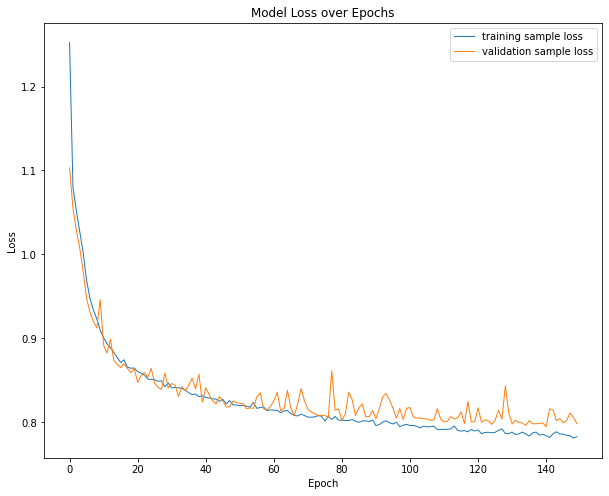

In [104]:
learningCurve(history)


In [105]:
labels = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index']


In [106]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    for i, label in enumerate(labels):
        if i==5:
            break
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
        
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'LSTM ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

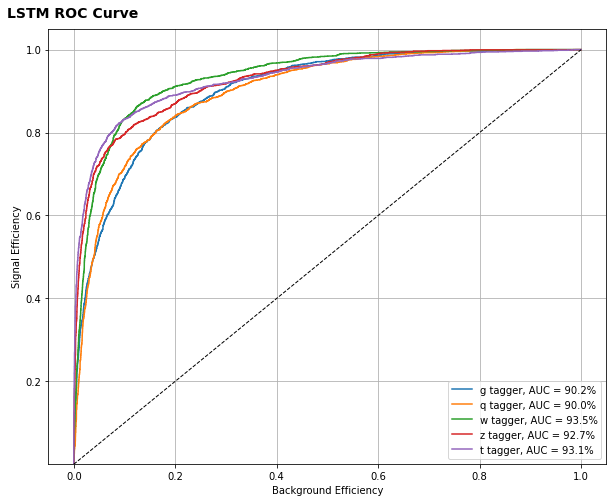

In [107]:
y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='two-layer')


In [109]:
model.save('drive/Shareddrives/Jet Classification/Data/5tagGRU6Feat.h5', )